In [1]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()

  Activating environment at `C:\Users\tge13\Documents\optimal_control_julia\lec_11\Project.toml`


In [2]:
using LinearAlgebra
using Plots
using ForwardDiff
using RobotZoo
using RobotDynamics
# using MatrixCalculus
using JLD2

In [3]:
#Acrobot Dynamics
a = RobotZoo.Acrobot()
h = 0.05

0.05

In [4]:
function dynamics_rk4(x,u)
    #RK4 integration with zero-order hold on u
    f1 = dynamics(a, x, u)
    f2 = dynamics(a, x + 0.5*h*f1, u)
    f3 = dynamics(a, x + 0.5*h*f2, u)
    f4 = dynamics(a, x + h*f3, u)

    return x + (h/6.0)*(f1 + 2*f2 + 2*f3 + f4)
end

dynamics_rk4 (generic function with 1 method)

In [5]:
function dfdx(x,u)
    return ForwardDiff.jacobian(_x -> dynamics_rk4(_x, u), x)
end

function dfdu(x,u)
    return ForwardDiff.derivative(_u -> dynamics_rk4(x, _u), u)
end

function dAdx(x,u)
    return ForwardDiff.jacobian(_x -> vec(dfdx(_x, u)), x)
end

function dBdx(x,u)
    return ForwardDiff.jacobian(_x -> dfdu(_x, u), x)
end

function dAdu(x,u)
    return ForwardDiff.derivative(_u -> vec(dfdx(x, _u)), u)
end

function dBdu(x,u)
    return ForwardDiff.derivative(_u -> dfdu(x, _u), u)
end

dBdu (generic function with 1 method)

In [6]:
function cost(xtraj,utraj)
    J = 0
    for k in 1:(Nt-1)
        J = J + 0.5*(xtraj[:,k] - xgoal)'*Q*(xtraj[:,k] - xgoal) + 0.5*R*utraj[k]*utraj[k]
    end
    J = J + 0.5*(xtraj[:,end] - xgoal)'*Qn*(xtraj[:,end] - xgoal)
end

cost (generic function with 1 method)

In [7]:
Nx = 4     # number of state
Nu = 1     # number of controls
Tfinal = 10.0 # final time
Nt = Int(Tfinal/h)+1    # number of time steps
thist = Array(range(0,h*(Nt-1), step=h));

In [8]:
# Cost weights
Q = Diagonal([1.0*ones(2); 0.1*ones(2)]);
R = 0.01;
Qn = Array(100.0*I(Nx));

## iLQR Algorithm

In [9]:
function backward_pass_ilqr!(p,P,d,K)

    ΔJ = 0.0
    p[:,end] .= Qn*(xtraj[:,end] - xgoal)
    P[:,:,end] .= Qn

    for k in (Nt-1):-1:1
        ∇ₓl = Q*(xtraj[:,k] - xgoal)
        ∇ᵤl = R*(utraj[k])

        A = dfdx(xtraj[:,k], utraj[k])
        B = dfdu(xtraj[:,k], utraj[k])
        
        gₓ = ∇ₓl + A'*p[:,k+1]
        gᵤ = ∇ᵤl + B'*p[:,k+1]

        # Gauss-Newton (iLQR)
        Gxx = Q + A'*P[:,:,k+1]*A
        Guu = R + B'*P[:,:,k+1]*B
        Gxu = A'*P[:,:,k+1]*B
        Gux = B'*P[:,:,k+1]*A

        d[k] = Guu\gᵤ
        K[:,:,k] .= Guu\Gux
    
        P[:,:,k] .= Gxx + K[:,:,k]'*Guu*K[:,:,k] - Gxu*K[:,:,k] - K[:,:,k]'*Gux
        p[:,k] .= dropdims(gₓ - K[:,:,k]'*gᵤ + K[:,:,k]'*Guu*d[k] - Gxu*d[k], dims=2)
    
        ΔJ += gᵤ'*d[k]
        
    end

    return ΔJ
end

backward_pass_ilqr! (generic function with 1 method)

In [11]:
#Initial guess
x0 = [-pi/2; 0; 0; 0]
xgoal = [pi/2; 0; 0; 0]
xtraj = kron(ones(1,Nt), x0)
utraj = randn(Nt-1);
#f = jldopen("guess.jld2", "r")
#utraj = f["utraj"];

In [12]:
#Initial Rollout
for k = 1:(Nt-1)
    xtraj[:,k+1] .= dynamics_rk4(xtraj[:,k],utraj[k])
end
J = cost(xtraj,utraj)

1492.6385416774542

In [13]:
d = ones(Nt-1)
xn = zeros(size(xtraj))
un = zeros(size(utraj))
iter = 0

while maximum(abs.(d[:])) > 1e-3
    p = zeros(Nx, Nt)
    P = zeros(Nx, Nx, Nt)
    d = ones(Nt-1)
    K = zeros(Nu,Nx,Nt-1)

    ΔJ = backward_pass_ilqr!(p,P,d,K)

    # Line Search
    xn[:,1] = x0
    α = 1.0

    for k in 1:(Nt-1)
        un[k] = utraj[k] - α*d[k] - dot(K[:,:,k],xn[:,k]-xtraj[:,k])
        xn[:,k+1] .= dynamics_rk4(xn[:,k], un[k])
    end
    Jn = cost(xn, un)
    
    while isnan(Jn) || Jn > (J - 1e-2*α*ΔJ)
        α *= 0.5
        for k in 1:(Nt-1)
            un[k] = utraj[k] - α*d[k] - dot(K[:,:,k],xn[:,k]-xtraj[:,k])
            xn[:,k+1] .= dynamics_rk4(xn[:,k], un[k])
        end
        Jn = cost(xn, un)
    end

    iter += 1
    J = Jn
    xtraj .= xn
    utraj .= un
end

In [14]:
iter, J

(330, 562.1228878155395)

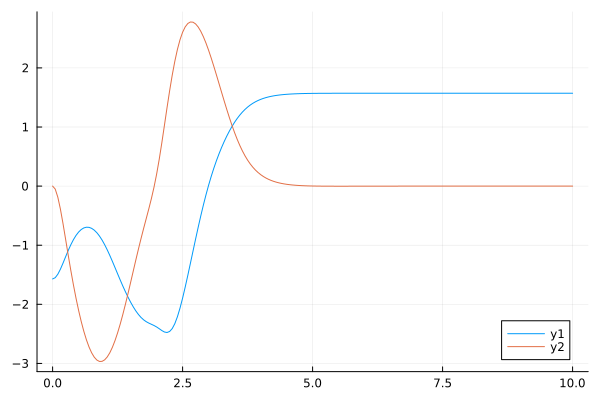

In [15]:
plot(thist,xtraj[1,:])
plot!(thist,xtraj[2,:])

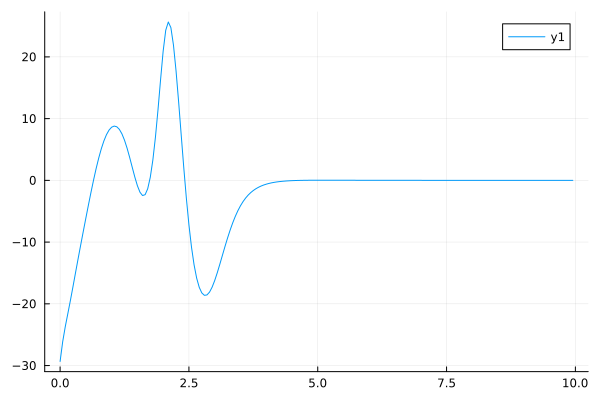

In [16]:
plot(thist[1:Nt-1],utraj)

In [17]:
using TrajOptPlots
using MeshCat
using StaticArrays

vis = Visualizer()
render(vis)

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
└ http://127.0.0.1:8700


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), Set{Any}(), ip"127.0.0.1", 8700))

In [18]:
TrajOptPlots.set_mesh!(vis, a)

MeshCat Visualizer with path /meshcat/robot/link1/joint at http://127.0.0.1:8700

In [19]:
X1 = [SVector{4}(x) for x in eachcol(xtraj)];
visualize!(vis, a, thist[end], X1)

## DDP Algorithm

In [10]:
comm_41 = I(4)

comm_44 = [
    1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;
    0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0;
    0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0;
    0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0;
    0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0;
    0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0;
    0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0;
    0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0;
    0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0;
    0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0;
    0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0;
    0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0;
    0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0;
    0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0;
    0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0;
    0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1;
]
A = randn(4,4)
vec(A) .- comm_44*vec(A')

16-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [11]:
function backward_pass_ddp!(p,P,d,K)

    ΔJ = 0.0
    p[:,end] .= Qn*(xtraj[:,end] - xgoal)
    P[:,:,end] .= Qn

    for k in (Nt-1):-1:1
        ∇ₓl = Q*(xtraj[:,k] - xgoal)
        ∇ᵤl = R*(utraj[k])

        A = dfdx(xtraj[:,k], utraj[k])
        B = dfdu(xtraj[:,k], utraj[k])
        
        gₓ = ∇ₓl + A'*p[:,k+1]
        gᵤ = ∇ᵤl + B'*p[:,k+1]

        # Full-Newton (DDP)
        Ax = dAdx(xtraj[:,k], utraj[k])
        Bx = dBdx(xtraj[:,k], utraj[k])
        Au = dAdu(xtraj[:,k], utraj[k])
        Bu = dBdu(xtraj[:,k], utraj[k])

        Gxx = Q + A'*P[:,:,k+1]*A + kron(p[:,k+1]', I(Nx))*comm_44*Ax
        Guu = R + B'*P[:,:,k+1]*B + (kron(p[:,k+1]', I(Nu))*comm_41*Bu)[1]
        Gxu = A'*P[:,:,k+1]*B + kron(p[:,k+1]', I(Nx))*comm_44*Au
        Gux = B'*P[:,:,k+1]*A + kron(p[:,k+1]', I(Nu))*comm_41*Bx

        # Regularization
        β = 0.1
        while !isposdef(Symmetric([Gxx Gxu; Gux Guu]))
            Gxx += β*A'*I*A
            Guu += β*B'*I*B
            Gux += β*B'*I*A
            Gxu += β*A'*I*B
            β *= 2
        end

        d[k] = Guu\gᵤ
        K[:,:,k] .= Guu\Gux
    
        P[:,:,k] .= Gxx + K[:,:,k]'*Guu*K[:,:,k] - Gxu*K[:,:,k] - K[:,:,k]'*Gux
        p[:,k] .= dropdims(gₓ - K[:,:,k]'*gᵤ + K[:,:,k]'*Guu*d[k] - Gxu*d[k], dims=2)
    
        ΔJ += gᵤ'*d[k]
        
    end

    return ΔJ
end

backward_pass_ddp! (generic function with 1 method)

In [22]:
#Initial guess
x0 = [-pi/2; 0; 0; 0]
xgoal = [pi/2; 0; 0; 0]
xtraj = kron(ones(1,Nt), x0)
utraj = randn(Nt-1);
#f = jldopen("guess.jld2", "r")
#utraj = f["utraj"];

In [23]:
#Initial Rollout
for k = 1:(Nt-1)
    xtraj[:,k+1] .= dynamics_rk4(xtraj[:,k],utraj[k])
end
J = cost(xtraj,utraj)

1506.6469468828614

In [24]:
d = ones(Nt-1)
xn = zeros(size(xtraj))
un = zeros(size(utraj))
iter = 0

while maximum(abs.(d[:])) > 1e-3
    p = zeros(Nx, Nt)
    P = zeros(Nx, Nx, Nt)
    d = ones(Nt-1)
    K = zeros(Nu,Nx,Nt-1)

    ΔJ = backward_pass_ilqr!(p,P,d,K)

    # Line Search
    xn[:,1] = x0
    α = 1.0

    for k in 1:(Nt-1)
        un[k] = utraj[k] - α*d[k] - dot(K[:,:,k],xn[:,k]-xtraj[:,k])
        xn[:,k+1] .= dynamics_rk4(xn[:,k], un[k])
    end
    Jn = cost(xn, un)
    
    while isnan(Jn) || Jn > (J - 1e-2*α*ΔJ)
        α *= 0.5
        for k in 1:(Nt-1)
            un[k] = utraj[k] - α*d[k] - dot(K[:,:,k],xn[:,k]-xtraj[:,k])
            xn[:,k+1] .= dynamics_rk4(xn[:,k], un[k])
        end
        Jn = cost(xn, un)
    end

    iter += 1
    J = Jn
    xtraj .= xn
    utraj .= un
end

In [25]:
iter, J

(330, 562.1228878135843)

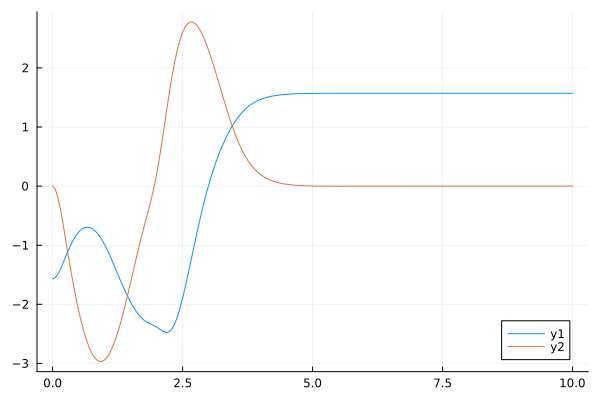

In [26]:
plot(thist,xtraj[1,:])
plot!(thist,xtraj[2,:])

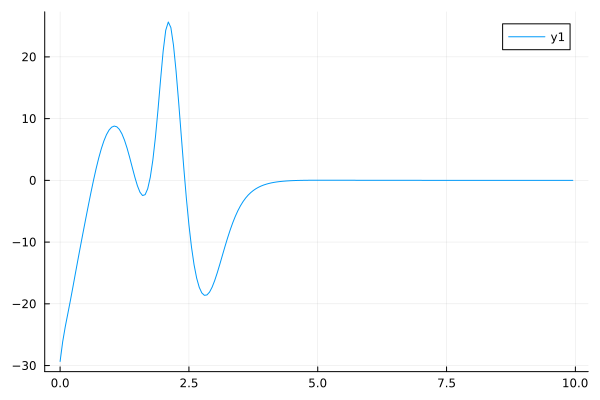

In [27]:
plot(thist[1:Nt-1],utraj)

In [28]:
using TrajOptPlots
using MeshCat
using StaticArrays

vis = Visualizer()
render(vis)

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
└ http://127.0.0.1:8701


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), Set{Any}(), ip"127.0.0.1", 8701))

In [29]:
TrajOptPlots.set_mesh!(vis, a)

MeshCat Visualizer with path /meshcat/robot/link1/joint at http://127.0.0.1:8701

In [30]:
X1 = [SVector{4}(x) for x in eachcol(xtraj)];
visualize!(vis, a, thist[end], X1)

## Bigger Control Penalty and Longer Time

In [35]:
Nx = 4     # number of state
Nu = 1     # number of controls
Tfinal = 10.0 # final time
Nt = Int(Tfinal/h)+1    # number of time steps
thist = Array(range(0,h*(Nt-1), step=h));

In [36]:
# Cost weights
Q = Diagonal([1.0*ones(2); 0.1*ones(2)]);
R = 0.02;
Qn = Array(100.0*I(Nx));

In [38]:
#Initial guess
x0 = [-pi/2; 0; 0; 0]
xgoal = [pi/2; 0; 0; 0]
xtraj = kron(ones(1,Nt), x0)
utraj = randn(Nt-1);

#Initial Rollout
for k = 1:(Nt-1)
    xtraj[:,k+1] .= dynamics_rk4(xtraj[:,k],utraj[k])
end
J = cost(xtraj,utraj)

d = ones(Nt-1)
xn = zeros(size(xtraj))
un = zeros(size(utraj))
iter = 0

while maximum(abs.(d[:])) > 1e-3
    p = zeros(Nx, Nt)
    P = zeros(Nx, Nx, Nt)
    d = ones(Nt-1)
    K = zeros(Nu,Nx,Nt-1)

    ΔJ = backward_pass_ilqr!(p,P,d,K)
    # ΔJ = backward_pass_ddp!(p,P,d,K)

    # Line Search
    xn[:,1] = x0
    α = 1.0

    for k in 1:(Nt-1)
        un[k] = utraj[k] - α*d[k] - dot(K[:,:,k],xn[:,k]-xtraj[:,k])
        xn[:,k+1] .= dynamics_rk4(xn[:,k], un[k])
    end
    Jn = cost(xn, un)
    
    while isnan(Jn) || Jn > (J - 1e-2*α*ΔJ)
        α *= 0.5
        for k in 1:(Nt-1)
            un[k] = utraj[k] - α*d[k] - dot(K[:,:,k],xn[:,k]-xtraj[:,k])
            xn[:,k+1] .= dynamics_rk4(xn[:,k], un[k])
        end
        Jn = cost(xn, un)
    end

    iter += 1
    J = Jn
    xtraj .= xn
    utraj .= un
end

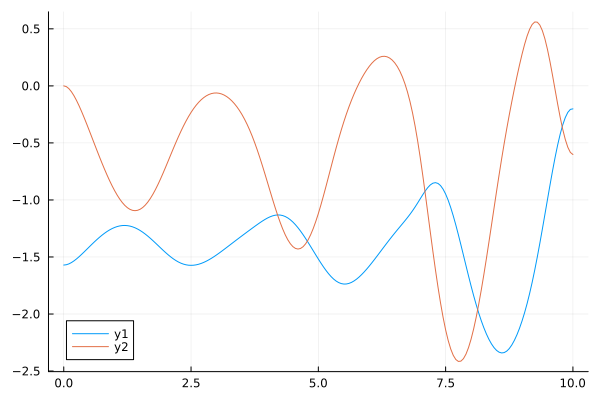

In [39]:
plot(thist,xtraj[1,:])
plot!(thist,xtraj[2,:])

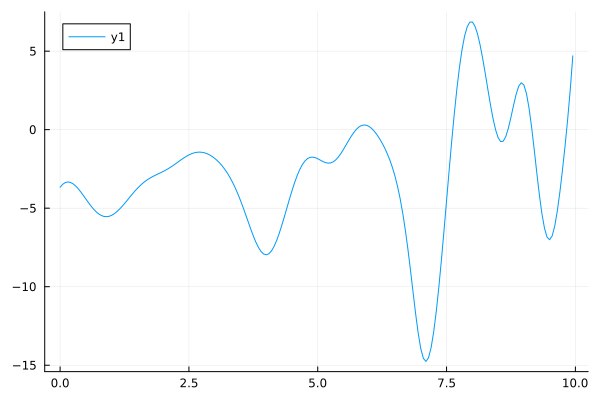

In [40]:
plot(thist[1:Nt-1],utraj)

In [89]:
using TrajOptPlots
using MeshCat
using StaticArrays

vis = Visualizer()
render(vis)

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
└ http://127.0.0.1:8701


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), Set{Any}(), ip"127.0.0.1", 8701))

In [90]:
TrajOptPlots.set_mesh!(vis, a)

MeshCat Visualizer with path /meshcat/robot/link1/joint at http://127.0.0.1:8701

In [91]:
X1 = [SVector{4}(x) for x in eachcol(xtraj)];
visualize!(vis, a, thist[end], X1)

## Change Initial guess

In [25]:
Nx = 4     # number of state
Nu = 1     # number of controls
Tfinal = 10.0 # final time
Nt = Int(Tfinal/h)+1    # number of time steps
thist = Array(range(0,h*(Nt-1), step=h));

In [26]:
# Cost weights
Q = Diagonal([1.0*ones(2); 0.1*ones(2)]);
R = 0.01;
Qn = Array(100.0*I(Nx));

In [29]:
#Initial guess
x0 = [-pi/2; 0; 0; 0]
xgoal = [pi/2; 0; 0; 0]
xtraj = kron(ones(1,Nt), x0)
utraj = randn(Nt-1);
f = jldopen("guess.jld2", "r")
utraj = f["utraj"];

#Initial Rollout
for k = 1:(Nt-1)
    xtraj[:,k+1] .= dynamics_rk4(xtraj[:,k],utraj[k])
end
J = cost(xtraj,utraj)

d = ones(Nt-1)
xn = zeros(size(xtraj))
un = zeros(size(utraj))
iter = 0

while maximum(abs.(d[:])) > 1e-3
    p = zeros(Nx, Nt)
    P = zeros(Nx, Nx, Nt)
    d = ones(Nt-1)
    K = zeros(Nu,Nx,Nt-1)

    ΔJ = backward_pass_ilqr!(p,P,d,K)

    # Line Search
    xn[:,1] = x0
    α = 1.0

    for k in 1:(Nt-1)
        un[k] = utraj[k] - α*d[k] - dot(K[:,:,k],xn[:,k]-xtraj[:,k])
        xn[:,k+1] .= dynamics_rk4(xn[:,k], un[k])
    end
    Jn = cost(xn, un)
    
    while isnan(Jn) || Jn > (J - 1e-2*α*ΔJ)
        α *= 0.5
        for k in 1:(Nt-1)
            un[k] = utraj[k] - α*d[k] - dot(K[:,:,k],xn[:,k]-xtraj[:,k])
            xn[:,k+1] .= dynamics_rk4(xn[:,k], un[k])
        end
        Jn = cost(xn, un)
    end

    iter += 1
    J = Jn
    xtraj .= xn
    utraj .= un
end

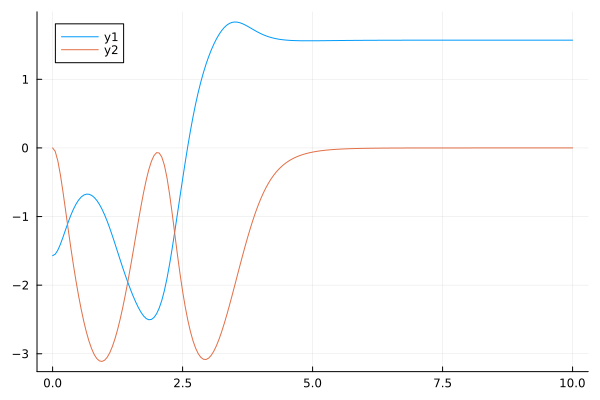

In [30]:
plot(thist,xtraj[1,:])
plot!(thist,xtraj[2,:])

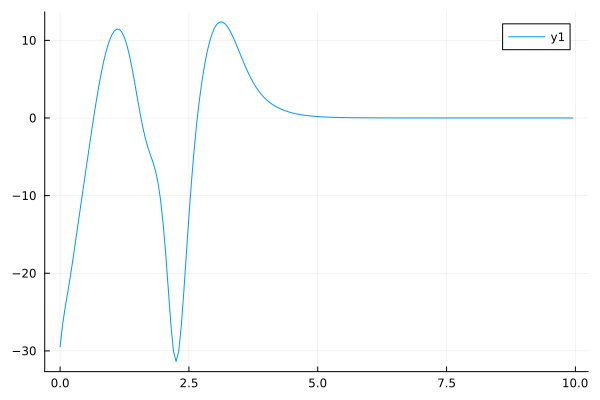

In [31]:
plot(thist[1:Nt-1],utraj)

In [32]:
using TrajOptPlots
using MeshCat
using StaticArrays

vis = Visualizer()
render(vis)

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
└ http://127.0.0.1:8702


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), Set{Any}(), ip"127.0.0.1", 8702))

In [33]:
TrajOptPlots.set_mesh!(vis, a)

MeshCat Visualizer with path /meshcat/robot/link1/joint at http://127.0.0.1:8702

In [34]:
X1 = [SVector{4}(x) for x in eachcol(xtraj)];
visualize!(vis, a, thist[end], X1)